# Projet en Traitement Automatique des Langues

### Classification par genre

- Extraction d'informations des textes
- Apprentissage sur le genre de chaque texte

Corpus choisi : Pièces de théatre classiques en français.

In [1]:
# coding : utf-8

# Import

# NPL
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Scientific calculation
from __future__ import division
import numpy as np

# Data manipulation
from lxml import etree
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Others
import glob 
import re
import os.path 

### Extraction d'information

##### Informations à extraire :
- Le genre (Classe)
- L'auteur
- Le type (vers ou prose)
- Taille moyenne des phrases
- La longueur du texte
- Longueur du texte
- Recurrence des mots les mots représentatifs du genre
- Nombre de personnages
- L'inspiration (Histoires chrétiennes, etc.)
- La structure (nombre d'actes)
- La période (le siècle)
- La longueur du texte
- La taille moyenne des phrases

In [2]:
# Quelques fonctions utiles

def tokenize(w):
    """ Tokenisation """
    token = nltk.word_tokenize(w)
    if len(token) > 0:
        return token[0]
    else:
        return ''

def get_tokens(liste):
    """ Renvoie la liste des tokens d'un texte """
    if(len(liste) > 0):
        tokens = []
        average = 0
        for s in liste:
            words = re.findall(r"[\w]+", s)
            average += len(words)
            for w in words:
                if len(w) > 3: # On ajoute que les mots de taille > 3
                    tokens.append(tokenize(w))
        average = average / len(liste)
        return (average, tokens)
    else:
        return (1, [])

def ajouter(liste, chaine):
    """ On ajoute la chaine a la liste si elle n'est pas vide """
    if len(chaine) > 0:
        liste.append(chaine)

def clean_text(text):
        if type(text) == type(''):
            text = text.lower() #lower case for everyone        
        else:
            text = ''
        return text #no_punctuation
    
def get_structure(s):
    """ 'Cinq actes' -> 5 """
    nombres = ['un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf']
    try:
        return int(nombres.index(s.split(' ')[0].lower()) + 1)
    except:
        return 0

In [3]:
# Classe python texte

class Oeuvre:
    """Classe définissant une oeuvre caractérisé par :

    - Un identificateur unique (int)
    - Son auteur
    - Son genre (Classe pour classification)
    - Son type (Vers / Prose)
    - L'inspiration (Histoires chrétiennes, etc.)
    - La structure (nombre d'actes)
    - La période (le siècle)
    - La taille
    - La taille moyenne des phrases
    - Le texte des dialogues
    - Le nombre de personnages
    - Score des genres
    - La longueur du texte

    """
    def __init__(self, t, i):
        """ t le nom du fichier XML et i un identificateur unique """
        """ On extrait les strings des balises qui nous interessent """
        a = 0
        g = 0
        ty = 0
        inspi = 0
        texte = []
        struct = 0
        perio = 0
        tai = 0
        nb_roles = 0
        
        tree = etree.parse(t)
        # On peut ajouter des attributs
        # Extraire plus d'intro
        for author in tree.xpath("/TEI/teiHeader/fileDesc/titleStmt/author"):
            a = author.text
        for genre in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/genre"):
            g = genre.text
        for type_ in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/type"):
            ty = type_.text
        for inspiration in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/inspiration"):
            inspi = inspiration.text
        for structure in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/structure"):
            struct = get_structure(structure.text)
        for periode in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/periode"):
            try:
                perio = int(periode.text[:2]) # On recupere seulement le siecle
            except:
                perio = 0
        for taille in tree.xpath("/TEI/teiHeader/fileDesc/SourceDesc/taille"):
            try:
                tai = int(taille.text.split('-')[0]) # On recupere la premiere valeur
            except:
                tai = 0
        for text in tree.xpath("/TEI/text/body/div1/div2/sp/p/s"):
            ajouter(texte, clean_text(text.text))
        for text in tree.xpath("/TEI/text/body/div1/div2/sp/l"):
            ajouter(texte, clean_text(text.text))
        
        for roles in tree.xpath("/TEI/text/front/castList/castItem"):
            nb_roles += 1

        average, texte = get_tokens(texte) # on tokenize le texte et on calcule la moyenne des tailles des phrases

        self.id = i
        self.author = a
        self.genre = g
        self.type = ty
        self.inspiration = inspi
        self.structure = struct
        self.periode = perio
        self.taille = tai
        self.average = average
        self.texte = texte
        self.tfidf = dict()
        self.tokens = []
        self.nb_roles = nb_roles
        self.scores = dict()
        self.longueur = len(texte)
        
    def genre_scores(self, genres):
        """ explication """
        # nom le nom du genre
        for nom in genres:
            self.scores[nom] = 0
        
        for w in self.texte: # on parcours chaque mot du texte
            for nom in genres: # genre la clé de genres
                if w in genres[nom].tokens:
                    self.scores[nom] += 1
        
        # pour obtenir des probas entre 0 et 1 plutot que des counts
        total = sum(self.scores.values())
        for nom in self.scores:
            if self.scores[nom] != 0:
                self.scores[nom] = self.scores[nom] / total
        
# Classe genre
class Genre: 
    """ 
    - Tokens : Les x mots les plus représentatifs du genre (TF-IDF max)
    """
    
    def __init__(self, nom):
        self.nom = nom
        self.texte = []
        self.tfidf = dict()
        self.tokens = []

### Lecture des fichiers XML

In [4]:
# Lecture des données
# Les fichiers sont dans /corpus/theatreClassique/XML/(*.xml)

def get_data(path):
    """ On parse tous les fichiers XML """
    datas = []
    l = glob.glob(path+'/*')
    count = 0
    for i in l:
        if os.path.isdir(i): listdirectory(i)
        else:
            if os.path.splitext(i)[1] == '.xml':
                
                datas.append(Oeuvre(i, count))
                count += 1
                
    return datas
                
corpus = get_data('corpus/theatreClassique/XML')

### Extraction des mots représentatifs de chaque genre

In [5]:
# Cette section extrait que les TFIDFS
# On veux extraire les mots les plus representatifs
# Par genre

def extraction(corpus):
    """ On passe d'une liste de tokens à une liste de mot-clés pertinents """
    
    nb = 70 # nb best qu'on selectionne
    
    # IDF : Nombre de documents d'apparitions / Nombre de documents
    idf = dict()
    genres = dict()
    
    for oeuvre in corpus:
        if not genres.has_key(oeuvre.genre):
            genres[oeuvre.genre] = Genre(oeuvre.genre)
        genres[oeuvre.genre].texte = genres[oeuvre.genre].texte + oeuvre.texte
    
    for genre in genres:
        oeuvre = genres[genre]
        # TF : Frequence brute de chaque mot
        tf = oeuvre.tfidf
        
        for w in oeuvre.texte:
            
            if not tf.has_key(w):
                tf[w] = 0
            tf[w] += 1
            
            if not idf.has_key(w):
                idf[w] = set()
            idf[w].add(oeuvre.nom) #.id)
                
        for e in tf:
            tf[e] = tf[e] / len(oeuvre.texte) # on divise la somme par le nombre total de mots (frequence)
            
        oeuvre.tfidf = tf # utile ??
            
    for e in idf:
        idf[e] = len(genres) / len(idf[e]) # frequence inverse par le nombre d'oeuvres
        # len pck idf contient l'ensemble des corpus d'apparition, on veux le nombre d'apparitions
    
    for genre in genres:
        oeuvre = genres[genre]
        for e in oeuvre.tfidf:
            oeuvre.tfidf[e] = oeuvre.tfidf[e] * idf[e] # TF-IDF
    
        # sel best
        bests = sorted(oeuvre.tfidf.items(), key=lambda x:x[1], reverse=True)[:nb] # nb best
        oeuvre.tokens = [bests[i][0] for i in range(len(bests))] # on retire les tfidfs pour ne garder que les mots
        
    return genres

### Création d'un dataframe contenant les informations

In [6]:
# On declare une dataframe

ids = [corpus[i].id for i in range(len(corpus))]
authors = [corpus[i].author for i in range(len(corpus))]
genres = [corpus[i].genre for i in range(len(corpus))]
types = [corpus[i].type for i in range(len(corpus))]
inspirations = [corpus[i].inspiration for i in range(len(corpus))]
structures = [corpus[i].structure for i in range(len(corpus))]
periodes = [corpus[i].periode for i in range(len(corpus))]
tailles = [corpus[i].taille for i in range(len(corpus))]
averages = [corpus[i].average for i in range(len(corpus))]
nb_roles = [corpus[i].nb_roles for i in range(len(corpus))]
longueurs = [corpus[i].longueur for i in range(len(corpus))]
#tok = [corpus[i].tokens for i in range(len(corpus))]

d = {'id': ids, 'author': authors, 'genre': genres, 'type' : types, 'inspiration': inspirations, 'structure': structures, 'periode': periodes, 'taille': tailles, 'average': averages, 'nb_roles': nb_roles, 'longueur' : longueurs} 
df = pd.DataFrame(data=d)

# intification
#df = df.apply(preprocessing.LabelEncoder().fit_transform)
mapping = {k: v for v, k in enumerate(df.author.unique())}
df['author'] = df.author.map(mapping)
mapping = {k: v for v, k in enumerate(df.inspiration.unique())}
df['inspiration'] = df.inspiration.map(mapping)
mapping = {k: v for v, k in enumerate(df.type.unique())}
df['type'] = df.type.map(mapping)
mapping = {k: v for v, k in enumerate(df.genre.unique())}
df['genre'] = df.genre.map(mapping)
# Attention, refaire l'intification des tokens pck là c'est clairement con

_class = 'genre'

y = df[_class]
X = df.drop([_class], axis = 1)
#X = X.drop(['id'], axis = 1) # Information inutile pour l'apprentissage

### Statistiques, distributions, visualisation

In [7]:
print(len(corpus))

# Distribution des auteurs
auteurs = set()
for texte in corpus:
    auteurs.add(texte.author)

# Distribution des genres 
# Au pif on obtient 20 % de reussite
# Surement des classes tres representees
# AUC ROC score ?
# Bar plot Genre
    
print(len(auteurs))
print(len(genres))

# reunir certains genres ?

# Tester l'entropie de chaque attribut

1030
310
1030


In [8]:
display(df)

,author,average,genre,id,inspiration,longueur,nb_roles,periode,structure,taille,type
0,0,8.500000,0,0,0,3187,9,16,5,1750,0
1,1,7.193516,1,1,1,3782,13,16,5,1750,0
2,2,5.016667,2,2,1,173,7,17,1,0,0
3,3,8.268537,0,3,2,2207,12,17,5,1500,0
4,4,6.962500,1,4,1,883,15,16,1,500,0
5,1,5.335731,1,5,1,1126,15,16,3,0,1
6,5,5.548780,3,6,1,725,5,17,1,0,1
7,6,5.082267,4,7,1,1388,22,16,5,0,2
8,7,5.586207,5,8,1,76,1,18,1,0,1
9,8,7.960818,0,9,2,2635,8,16,5,1500,0


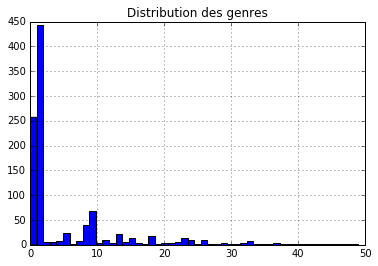

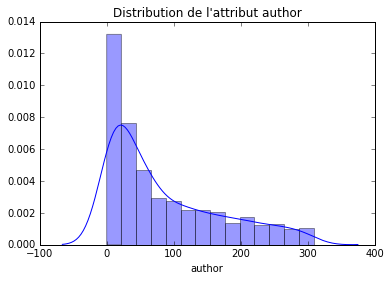

Distribution des genres en fonction de l'attribut author


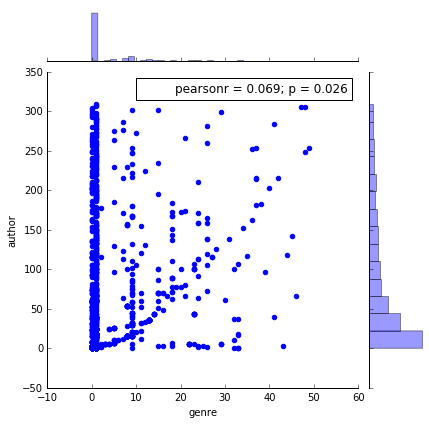

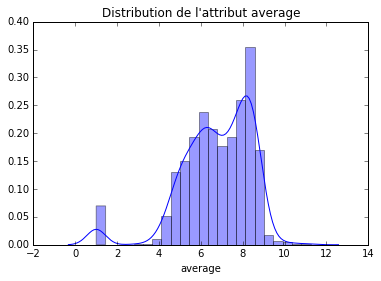

Distribution des genres en fonction de l'attribut average


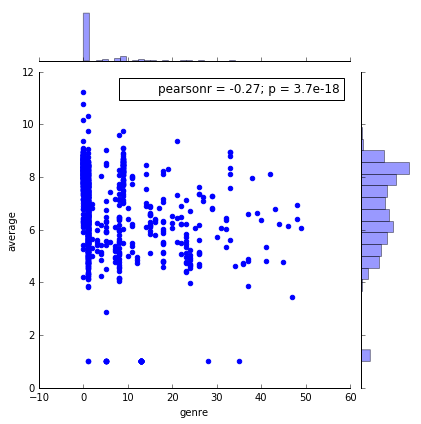

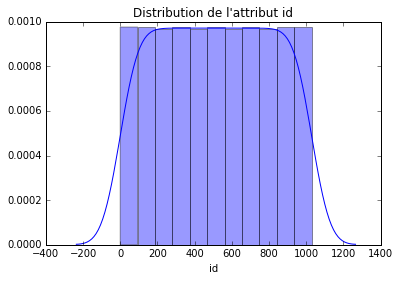

Distribution des genres en fonction de l'attribut id


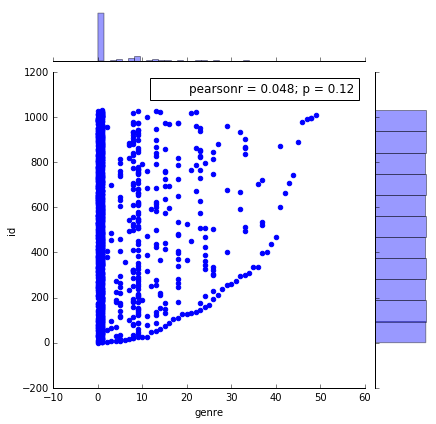

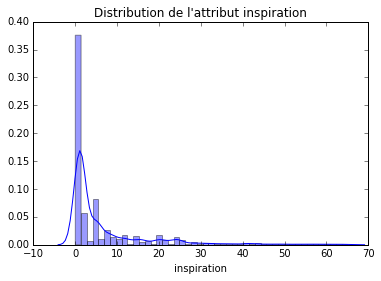

Distribution des genres en fonction de l'attribut inspiration


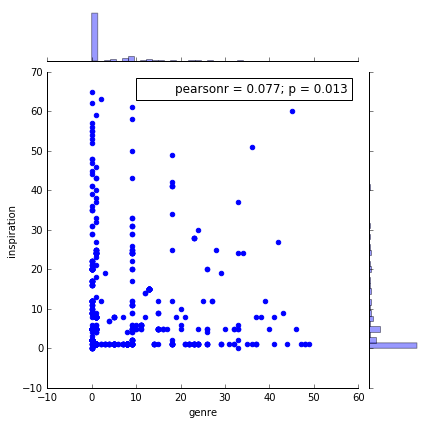

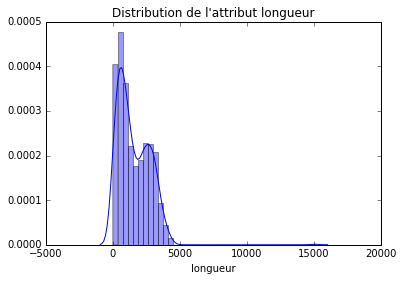

Distribution des genres en fonction de l'attribut longueur


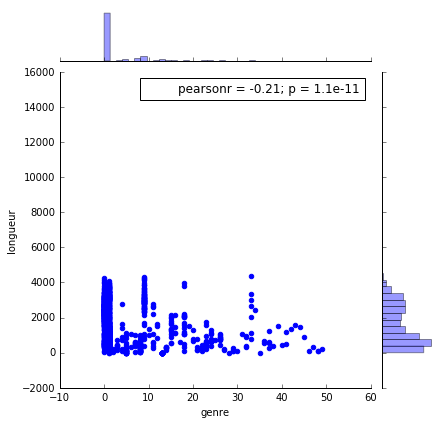

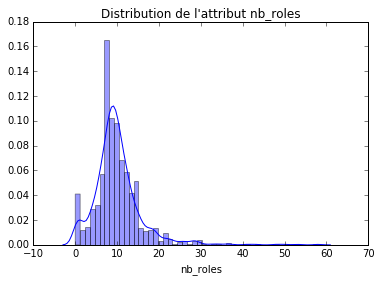

Distribution des genres en fonction de l'attribut nb_roles


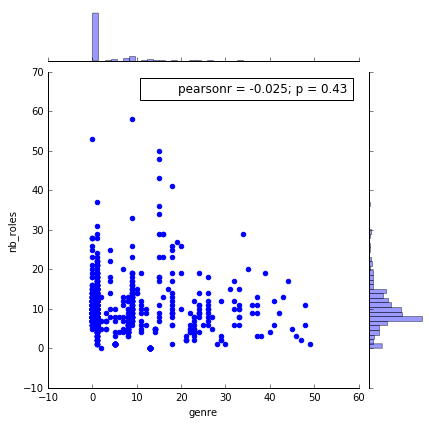

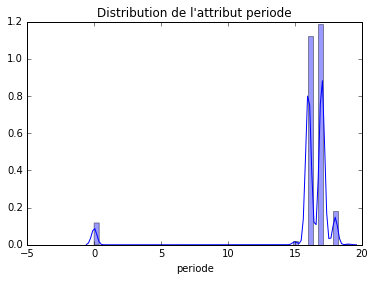

Distribution des genres en fonction de l'attribut periode


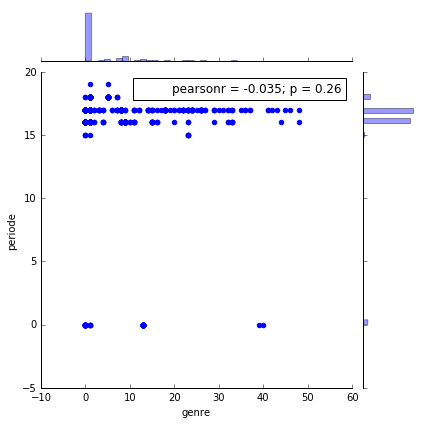

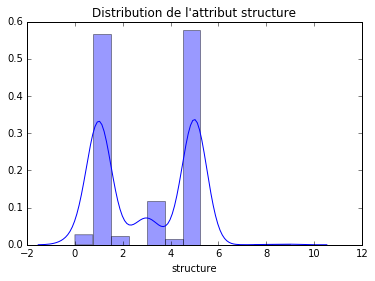

Distribution des genres en fonction de l'attribut structure


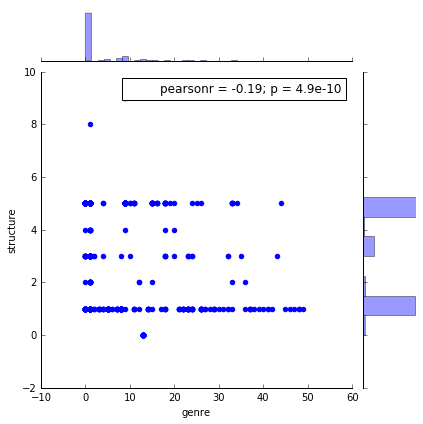

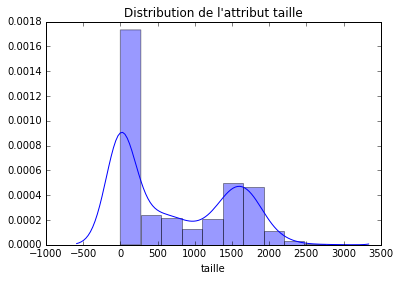

Distribution des genres en fonction de l'attribut taille


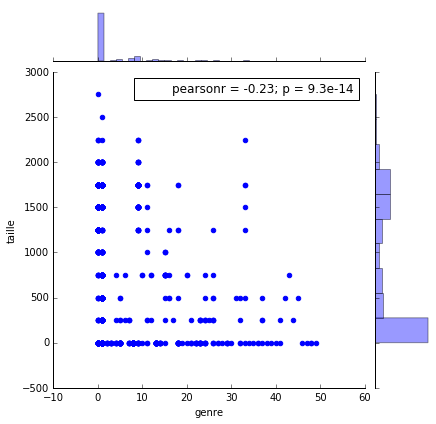

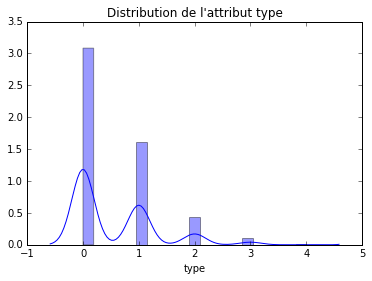

Distribution des genres en fonction de l'attribut type


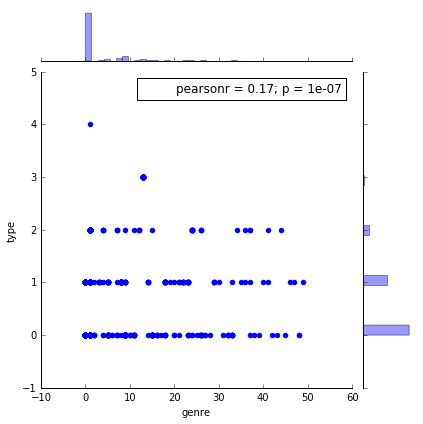

In [9]:
# Visualisation

df.genre.hist(bins=50)
plt.title('Distribution des genres')
plt.show()

for feature in X.columns:

    sns.distplot(df[feature])
    plt.title("Distribution de l'attribut {}".format(feature))
    plt.show()

    sns.jointplot(x="genre", y=feature, data=df)
    print("Distribution des genres en fonction de l'attribut {}".format(feature))
    plt.show()


### Apprentissage, classification, validation

In [10]:
# Sampling, cross-validation
samp = len(X)
x_train, x_validation, y_train, y_validation = train_test_split(X[:samp], y[:samp], test_size=0.2, random_state=0)

x_train['id']

corpus_train = []

for i in x_train['id']:
    corpus_train.append(corpus[i])

In [11]:
# Calcul des mots representatifs des classes sur l'ensemble d'entrainement
genres = extraction(corpus_train)

In [12]:
# Score genre
for t in corpus:
    t.genre_scores(genres)

In [13]:
# on recupere les 10 genres les plus probables d'apres le lexique
import operator

def genres_probables(scores):
    """ Renvoi le premier genre le plus probables d'apres le lexique """
    nb = 1
    s = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[:nb]
    res = []
    for e in s:
        res.append(e[0])
    return res

In [14]:
# on remplit les dataframes avec les scores
for index, row in x_train.iterrows():
    s = corpus[index].scores
    res = genres_probables(s)
    for i, nom in enumerate(res):
        x_train.loc[index, str(i)] = mapping[nom] # mapping sur les genres
        
for index, row in x_validation.iterrows():
    s = corpus[index].scores
    res = genres_probables(s)
    
    for i, nom in enumerate(res):
        x_validation.loc[index, str(i)] = mapping[nom]

In [15]:
x_train

,author,average,id,inspiration,longueur,nb_roles,periode,structure,taille,type,0
957,6,5.317073,957,63,125,0,16,3,0,0,2.0
267,23,8.777542,267,5,2164,10,17,5,1500,0,0.0
863,41,7.768116,863,12,2806,7,16,5,1500,0,9.0
342,167,6.202454,342,1,986,9,18,5,0,1,1.0
416,10,5.142857,416,1,14,2,18,1,0,1,1.0
644,37,6.343915,644,1,1121,9,16,1,500,0,1.0
1001,171,6.678363,1001,4,611,6,17,1,750,0,0.0
717,6,8.228571,717,1,1180,9,16,1,500,0,1.0
384,14,7.132132,384,1,1226,6,17,3,750,0,1.0
704,3,8.497942,704,31,2122,9,17,5,1250,0,0.0


In [16]:
# Validation, test

#CL = DecisionTreeClassifier()
CL = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0)

CL.fit(x_train.values, y_train.values)
print(CL.score(x_validation.values, y_validation.values))

# Avec les nouvelles infos on monte a 70% avec l'arbre de decision
# Avec random forest 78%
# 72 % avec tous les games
# 77% avec juste le premier

0.776699029126


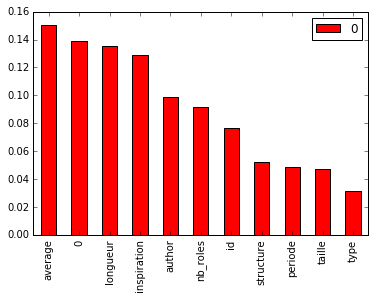

In [523]:
importances = list(zip(CL.feature_importances_, x_train.columns))
importances.sort(reverse=True)
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar', color='red')
plt.show()